In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import pandas as pd


from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression

import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer


In [37]:
# vv 가지고 class로 변환하기

def make_class(vv):
    if vv < 0.1:
        return 0
    elif vv < 0.2:
        return 1
    elif vv < 0.5:
        return 2
    elif vv < 1.0:
        return 3
    elif vv < 2.0:
        return 4
    elif vv < 5.0:
        return 5
    elif vv < 10.0:
        return 6
    elif vv < 20.0:
        return 7
    elif vv < 30.0:
        return 8
    else:
        return 9

In [27]:
train = pd.read_csv("train2.csv")
test = pd.read_csv("test2.csv")

In [72]:
train2 = train[train['ef_year'] == 2003]

In [57]:
# 정규성 확인

from scipy.stats import shapiro

# 예시 데이터
data = train['v09']

stat, p = shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))

# 해석
alpha = 0.05
if p > alpha:
    print('샘플은 정규분포를 따릅니다 (귀무가설 채택)')
else:
    print('샘플은 정규분포를 따르지 않습니다 (귀무가설 기각)')

Statistics=0.097, p=0.000
샘플은 정규분포를 따르지 않습니다 (귀무가설 기각)


c:\Users\mm\anaconda3\envs\flood\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


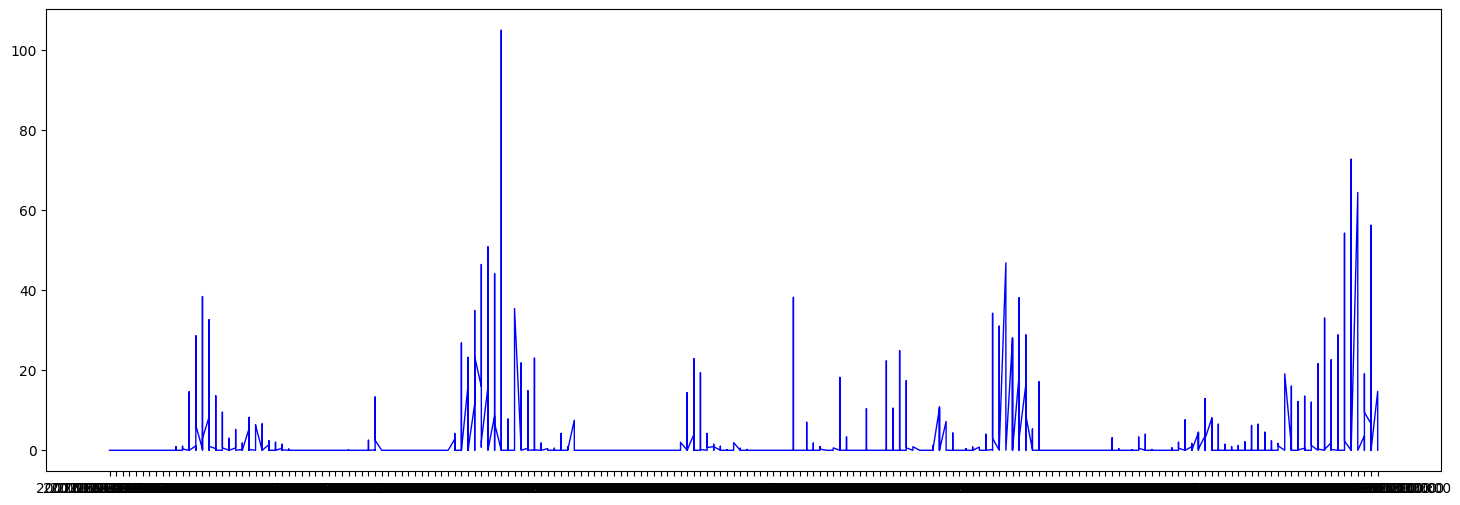

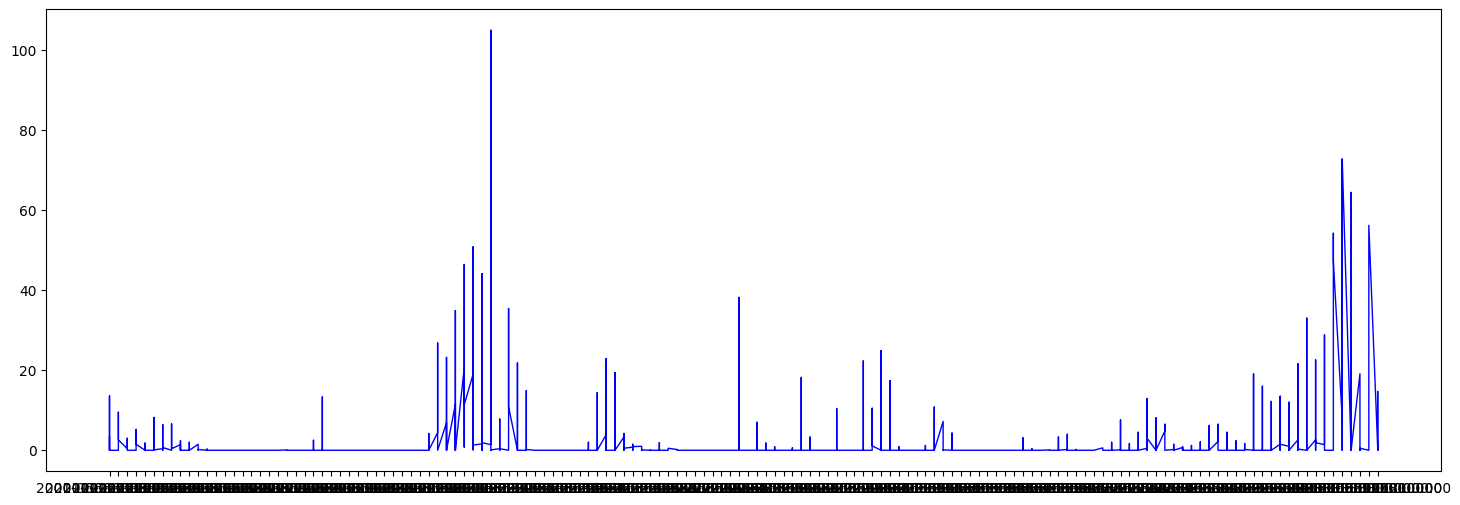

In [68]:
# 장마 기간 시각화, 결정

train_23 = train[((train['ef_month'] == 6) & (train['ef_day'] >= 23)) | (train['ef_month'] == 7 & (train['ef_day'] <= 26))]
train_23 = train_23.sort_values('ef_datetime')



plt.figure(figsize=(18, 6))
plt.plot(train_23['ef_datetime'], train_23['vv'], linestyle='-', color='b', label='vv', linewidth=1)

train_25 = train[((train['ef_month'] == 6) & (train['ef_day'] >= 25)) | (train['ef_month'] == 7 & (train['ef_day'] <= 24))]
train_25 = train_25.sort_values('ef_datetime')



plt.figure(figsize=(18, 6))
plt.plot(train_25['ef_datetime'], train_25['vv'], linestyle='-', color='b', label='vv', linewidth=1)

In [74]:
# 장마 변수 추가

train['season'] = ((train['ef_month'] == 6) & (train['ef_day'] >= 23)) | (train['ef_month'] == 7 & (train['ef_day'] <= 26))
train['season'] = train['season'].astype(int)
test['season'] = ((test['ef_month'] == 6) & (test['ef_day'] >= 23)) | (test['ef_month'] == 7 & (test['ef_day'] <= 26))
test['season'] = test['season'].astype(int)

# 출처 : https://data.kma.go.kr/climate/rainySeason/selectRainySeasonList.do


In [75]:
# fc_time 데이터 통합
def aggregate_fc_times(df):
    agg_funcs = {
        'v01': ['mean', 'max', 'min'],
        'v02': ['mean', 'max', 'min'],
        'v03': ['mean', 'max', 'min'],
        'v04': ['mean', 'max', 'min'],
        'v05': ['mean', 'max', 'min'],
        'v06': ['mean', 'max', 'min'],
        'v07': ['mean', 'max', 'min'],
        'v08': ['mean', 'max', 'min'],
        'v09': ['mean', 'max', 'min']
    }
    df_agg = df.groupby(['ef_datetime', 'stn4contest']).agg(agg_funcs)
    df_agg.columns = ['_'.join(col).strip() for col in df_agg.columns.values]

    # dh가 가장 작은 값 선택
    idx_min_dh = df.groupby(['ef_datetime', 'stn4contest'])['dh'].idxmin()
    recent_values = df.loc[idx_min_dh, ['ef_datetime', 'stn4contest', 
                                        'v01', 'v02', 'v03', 'v04', 'v05', 
                                        'v06', 'v07', 'v08', 'v09', 'dh']]
    
    # 컬럼 이름 변경 (최근 값을 나타내기 위해)
    recent_values.columns = ['ef_datetime', 'stn4contest',
                             'recent_v01', 'recent_v02', 'recent_v03', 'recent_v04', 'recent_v05', 
                             'recent_v06', 'recent_v07', 'recent_v08', 'recent_v09', 'recent_dh']
    
    
    # Aggregated Data와 Recent Values 병합
    df_merged = pd.merge(df_agg, recent_values, on=['ef_datetime', 'stn4contest'])

    
    return df_merged

train_agg = aggregate_fc_times(train)
test_agg = aggregate_fc_times(test)


In [65]:
# 시간 관련 피처 생성 (Sine/Cosine 변환)
def add_sin_cos_features(df, col):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / df[col].max())
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / df[col].max())
    return df

# 타겟 변수 추가
def add_target_variable(df_agg, original_df):
    target = original_df.groupby(['ef_datetime', 'stn4contest'])['vv'].first().reset_index()
    df_agg = pd.merge(df_agg, target, on=['ef_datetime', 'stn4contest'], how='left')
    return df_agg

# 장마 변수 추가
def add_season(df_agg, original_df):
    target = original_df.groupby(['ef_datetime', 'stn4contest'])['season'].first().reset_index()
    df_agg = pd.merge(df_agg, target, on=['ef_datetime', 'stn4contest'], how='left')
    return df_agg


# 시간 변수 추가
def add_time_hour(df_agg, original_df):
    target = original_df.groupby(['ef_datetime', 'stn4contest'])['ef_hour'].first().reset_index()
    df_agg = pd.merge(df_agg, target, on=['ef_datetime', 'stn4contest'], how='left')
    return df_agg


# 시간 변수 추가
train_agg = add_time_hour(train_agg, train)
test_agg = add_time_hour(test_agg, test)

# 장마 변수 추가
train_agg = add_season(train_agg, train)
test_agg = add_season(test_agg, test)

# 시간 관련 피처 생성
train_agg = add_sin_cos_features(train_agg, 'ef_hour')
test_agg = add_sin_cos_features(test_agg, 'ef_hour')

# 타겟 변수 추가
train_agg = add_target_variable(train_agg, train)


In [66]:
# train/test split
train_df = train_agg[(train_agg['ef_datetime'].str[:4] == '2001') | (train_agg['ef_datetime'].str[:4] == '2002')]
test_df = train_agg[train_agg['ef_datetime'].str[:4] == '2003']
# train_df = train_agg[train_agg['ef_datetime'].dt.year == 2001  | (train_agg['ef_datetime'].dt.year == 2002) ]
# test_df = train_agg[train_agg['ef_datetime'].dt.year == 2003]

# Feature와 target 설정 (train으로 테스트)
X_train = train_df.drop(columns=['vv', 'ef_datetime', 'ef_hour'])
y_train = train_df['vv']
X_test = test_df.drop(columns=['vv','ef_datetime', 'ef_hour'])
y_test = test_df['vv']

# test 예측
# X_train = train_agg.drop(columns=['vv', 'ef_datetime', 'ef_hour'])
# y_train = train_agg['vv']
# X_test = test_agg.drop(columns=['ef_datetime', 'ef_hour'])
# # # y_test = test_df['vv']




# # 데이터 스케일링
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)


# 정규분포를 따르지 않으므로 minmax 채택
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [76]:
# 평가 지표 만들기 CSI

def custom_score(y_pred):
    pred_df = pd.DataFrame({
        'ef_datetime': test_df['ef_datetime'],
        'stn4contest': test_df['stn4contest'],
        'pred': y_pred
    })

    test_merged = pd.merge(train2, pred_df, on=['ef_datetime', 'stn4contest'], how='left')

    test_merged = test_merged.dropna(subset=['pred'])

    # class_interval 만들기
    test_merged['real_class'] = test_merged['vv'].apply(make_class)
    test_merged['pred_class'] = test_merged['pred'].apply(make_class)

    # CSI 점수 검증하기

    H = ((test_merged['real_class'] == test_merged['pred_class']) & (test_merged['real_class'] > 0)).sum()
    F = ((test_merged['real_class'] != test_merged['pred_class']) & (test_merged['pred_class'] > 0)).sum()
    M = ((test_merged['real_class'] > 0) & (test_merged['pred_class'] == 0)).sum()

    # CSI 계산
    CSI = H / (H + F + M)
    
    return CSI

custom_scorer = make_scorer(custom_score, greater_is_better=True)

# grid_search = GridSearchCV(model, param_grid, cv=3, scoring=custom_scorer, n_jobs=-1)

In [83]:
# RandomForestRegressor

# 모델 학습
model = RandomForestRegressor()
param_grid = {
    'max_features' : ['sqrt', 'log2'],
    'max_depth': [8, 10, 12],
    'n_estimators': [100, 200, 300],
    'bootstrap': [True, False]
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=custom_scorer)
grid_search.fit(X_train, y_train)

# 최적 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# 성능 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
CSI = custom_score(y_pred)

print(f'MSE: {mse}')
print(f'R2: {r2}')
print(f'CSI: {CSI}')
print(best_model)



c:\Users\mm\anaconda3\envs\flood\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\mm\anaconda3\envs\flood\lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\mm\anaconda3\envs\flood\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "c:\Users\mm\anaconda3\envs\flood\lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
TypeError: custom_score() takes 1 positional argument but 2 were given

  warnings.warn(
c:\Users\mm\anaconda3\envs\flood\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring f

MSE: 10.600161936801628
R2: 0.3957689028841904
CSI: 0.07862532677313668
RandomForestRegressor(max_depth=8, max_features='sqrt')


In [85]:
# 모델 학습
model = XGBRegressor()
param_grid = {
    'max_depth': [8, 10, 12],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=custom_scorer)
grid_search.fit(X_train, y_train)

# 최적 모델로 예측
best_model = grid_search.best_estimator_
y_pred_xgb = best_model.predict(X_test)

# 성능 평가
mse = mean_squared_error(y_test, y_pred_xgb)
r2 = r2_score(y_test, y_pred_xgb)
CSI = custom_score(y_pred_xgb)

print(f'MSE: {mse}')
print(f'R2: {r2}')
print(f'CSI: {CSI}')
print(best_model)

MSE: 12.0812664497487
R2: 0.3113428903254416
CSI: 0.031785628067916634
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


In [86]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

grid_search_gb = GridSearchCV(GradientBoostingRegressor(), param_grid, cv=5, scoring=custom_scorer, n_jobs=-1)
grid_search_gb.fit(X_train, y_train)
best_gb = grid_search_gb.best_estimator_
print('Best Parameters for GradientBoosting:', grid_search_gb.best_params_)

# 최적 모델로 예측
y_pred_gb = best_gb.predict(X_test)

# 성능 평가
mse = mean_squared_error(y_test, y_pred_gb)
r2 = r2_score(y_test, y_pred_gb)
CSI = custom_score(y_pred_gb)

print(f'MSE: {mse}')
print(f'R2: {r2}')
print(f'CSI: {CSI}')
print(best_gb)

c:\Users\mm\anaconda3\envs\flood\lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters for GradientBoosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
MSE: 10.600161936801628
R2: 0.31718995774507197
CSI: 0.031742298097814314
GradientBoostingRegressor(learning_rate=0.01)


In [ ]:
# 신경망 모델
model = MLPRegressor(max_iter=500, random_state=1)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'hidden_layer_sizes': [(50, 50), (100, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.001, 0.01]
}

# GridSearchCV 설정
# grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 최적 모델로 예측
best_model = grid_search.best_estimator_
y_pred_mlp = best_model.predict(X_test)


# 성능 평가
mse = mean_squared_error(y_test, y_pred_mlp)
r2 = r2_score(y_test, y_pred_mlp)
CSI = custom_score(y_pred_mlp)

print(f'MSE: {mse}')
print(f'R2: {r2}')
print(f'CSI: {CSI}')
print(best_model)

c:\Users\mm\anaconda3\envs\flood\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\mm\anaconda3\envs\flood\lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\mm\anaconda3\envs\flood\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "c:\Users\mm\anaconda3\envs\flood\lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
TypeError: custom_score() takes 1 positional argument but 2 were given

  warnings.warn(
c:\Users\mm\anaconda3\envs\flood\lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more o

MSE: 10.600161936801628
R2: 0.3113428903254416
CSI: 0.031785628067916634
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


In [114]:
# best modeling


# 모델 학습
model = RandomForestRegressor(bootstrap=False,
                              max_depth=8,
                              max_features='log2',
                              n_estimators=200)
model.fit(X_train, y_train)

# 예측
y_pred_random = model.predict(X_test)


# 성능 평가
CSI = custom_score(y_pred_random)

print(f'CSI: {CSI}')

CSI: 0.08262940433834501


In [115]:
pred_df = pd.DataFrame({
    'ef_datetime': test_df['ef_datetime'],
    'stn4contest': test_df['stn4contest'],
    'pred': y_pred_random
})

test_merged = pd.merge(train2, pred_df, on=['ef_datetime', 'stn4contest'], how='left')

test_merged = test_merged.dropna(subset=['pred'])

# class_interval 만들기
test_merged['real_class'] = test_merged['vv'].apply(make_class)
test_merged['pred_class'] = test_merged['pred'].apply(make_class)

# CSI 점수 검증하기

H = ((test_merged['real_class'] == test_merged['pred_class']) & (test_merged['real_class'] > 0)).sum()
F = ((test_merged['real_class'] != test_merged['pred_class']) & (test_merged['pred_class'] > 0)).sum()
M = ((test_merged['real_class'] > 0) & (test_merged['pred_class'] == 0)).sum()

# CSI 계산
CSI = H / (H + F + M)

# 결과 출력
print("H =", H)
print("F =", F)
print("M =", M)
print("CSI =", CSI)

H = 14399
F = 157548
M = 2313
CSI = 0.08262940433834501
